In [21]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning / TS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Sklearn models & plumbing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier, AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)

warnings.filterwarnings("ignore")
RANDOM_STATE = 42

In [22]:
forecast_files = range(1, 7)
daily_peaks = None

for n in forecast_files:
    file_path = f"IESO-Ontario Demand 2022-2025 {n} day ahead.csv"
    df_temp = pd.read_csv(file_path)
    # Remove unnamed columns that may appear in the CSV
    df_temp = df_temp.loc[:, ~df_temp.columns.str.contains('^Unnamed')]
    # Create datetime and date columns
    df_temp['datetime'] = pd.to_datetime(df_temp['Date'] + ' ' + df_temp['Time'], dayfirst=True, errors='coerce')
    df_temp['date'] = df_temp['datetime'].dt.date
    # Aggregate to find daily maximum (peak) values for each predictor and the actual load
    agg = df_temp.groupby('date').agg({
        'ECA: IESO-Ontario Demand Historic Forecast': 'max',
        'RTO: IESO-Ontario Demand Historic Forecast': 'max',
        'TESLA: IESO-Ontario Demand Historic Forecast': 'max',
        'TESLA: IESO-Ontario Demand Actual': 'max'
    }).reset_index()

    # Rename prediction columns to reflect the forecast horizon. The actual peak is kept only for the 1‑day horizon.
    rename_map = {
        'ECA: IESO-Ontario Demand Historic Forecast': f'ECA_peak_{n}d',
        'RTO: IESO-Ontario Demand Historic Forecast': f'RTO_peak_{n}d',
        'TESLA: IESO-Ontario Demand Historic Forecast': f'TESLA_pred_peak_{n}d'
    }
    agg = agg.rename(columns=rename_map)
    if n == 1:
        agg = agg.rename(columns={'TESLA: IESO-Ontario Demand Actual': 'actual_peak'})
    else:
        # Drop the actual column for horizons other than 1 day ahead
        agg = agg.drop(columns=['TESLA: IESO-Ontario Demand Actual'])
    # Merge the current horizon's daily peaks into the master DataFrame
    if daily_peaks is None:
        daily_peaks = agg
    else:
        daily_peaks = pd.merge(daily_peaks, agg, on='date', how='outer')

# Build timestamp and calendar fields
daily_peaks = daily_peaks.sort_values('date').reset_index(drop=True)
daily_peaks['timestamp'] = pd.to_datetime(daily_peaks['date'])
daily_peaks = daily_peaks.drop(columns=['date'])
daily_peaks['year'] = daily_peaks['timestamp'].dt.year
daily_peaks['month'] = daily_peaks['timestamp'].dt.month
daily_peaks['day'] = daily_peaks['timestamp'].dt.day

# Drop rows with missing Actual (do NOT ffill/bfill targets)
daily_peaks = daily_peaks.dropna(subset=['actual_peak']).reset_index(drop=True)

daily_peaks.head()

,ECA_peak_1d,RTO_peak_1d,TESLA_pred_peak_1d,actual_peak,ECA_peak_2d,RTO_peak_2d,TESLA_pred_peak_2d,ECA_peak_3d,RTO_peak_3d,TESLA_pred_peak_3d,...,ECA_peak_5d,RTO_peak_5d,TESLA_pred_peak_5d,ECA_peak_6d,RTO_peak_6d,TESLA_pred_peak_6d,timestamp,year,month,day
0,17310.5,17025.45,17025.45,16954.95,17475.6,17043.95,17043.95,17463.6,17010.40,17010.40,...,17463.6,17010.40,17010.40,17840.9,17581.75,17581.75,2022-01-01,2022,1,1
1,18871.0,19026.75,19026.75,18923.03,18786.2,18964.95,18964.95,18799.3,18996.50,18996.50,...,19558.7,19031.80,19031.80,19456.6,19394.10,19394.10,2022-01-02,2022,1,2
2,20130.1,20323.15,20323.15,20051.29,19924.1,20147.70,20147.70,19919.8,20304.15,20304.15,...,18846.3,19064.90,19064.90,18811.4,19031.55,19031.55,2022-01-03,2022,1,3
3,19548.8,19115.85,19115.85,19408.90,19387.7,19085.10,19085.10,19354.1,18939.90,18939.90,...,16516.5,16749.45,16749.45,16364.1,16493.05,16493.05,2022-01-04,2022,1,4
4,19494.2,19147.90,19147.90,19338.73,19794.5,19100.40,19100.40,19751.8,19011.60,19011.60,...,14541.7,14614.20,14614.20,14533.9,14699.70,14699.70,2022-01-05,2022,1,5


In [23]:
daily_peaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ECA_peak_1d         1227 non-null   float64       
 1   RTO_peak_1d         1227 non-null   float64       
 2   TESLA_pred_peak_1d  1227 non-null   float64       
 3   actual_peak         1227 non-null   float64       
 4   ECA_peak_2d         1227 non-null   float64       
 5   RTO_peak_2d         1227 non-null   float64       
 6   TESLA_pred_peak_2d  1227 non-null   float64       
 7   ECA_peak_3d         1227 non-null   float64       
 8   RTO_peak_3d         1227 non-null   float64       
 9   TESLA_pred_peak_3d  1227 non-null   float64       
 10  ECA_peak_4d         1227 non-null   float64       
 11  RTO_peak_4d         1227 non-null   float64       
 12  TESLA_pred_peak_4d  1227 non-null   float64       
 13  ECA_peak_5d         453 non-null    float64     

In [24]:
# Descriptive statistics
stats = daily_peaks[[
    'actual_peak',
    'ECA_peak_1d',
    'RTO_peak_1d',
    'TESLA_pred_peak_1d'
]].describe()
stats

,actual_peak,ECA_peak_1d,RTO_peak_1d,TESLA_pred_peak_1d
count,1227.000000,1227.000000,1227.000000,1227.000000
mean,18135.832820,17856.211410,18093.216341,18093.216341
std,1879.666501,1619.048755,1846.455093,1846.455093
min,13303.840000,13631.700000,13696.100000,13696.100000
25%,16565.895000,16568.250000,16603.775000,16603.775000
50%,18139.780000,17909.000000,18103.450000,18103.450000
75%,19545.150000,19257.800000,19438.875000,19438.875000
max,23851.820000,21132.100000,24339.550000,24339.550000


In [25]:
# Check for missing values
missing = daily_peaks.isna().sum()
missing

ECA_peak_1d             0
RTO_peak_1d             0
TESLA_pred_peak_1d      0
actual_peak             0
ECA_peak_2d             0
RTO_peak_2d             0
TESLA_pred_peak_2d      0
ECA_peak_3d             0
RTO_peak_3d             0
TESLA_pred_peak_3d      0
ECA_peak_4d             0
RTO_peak_4d             0
TESLA_pred_peak_4d      0
ECA_peak_5d           774
RTO_peak_5d           774
TESLA_pred_peak_5d    774
ECA_peak_6d           774
RTO_peak_6d           774
TESLA_pred_peak_6d    774
timestamp               0
year                    0
month                   0
day                     0
dtype: int64

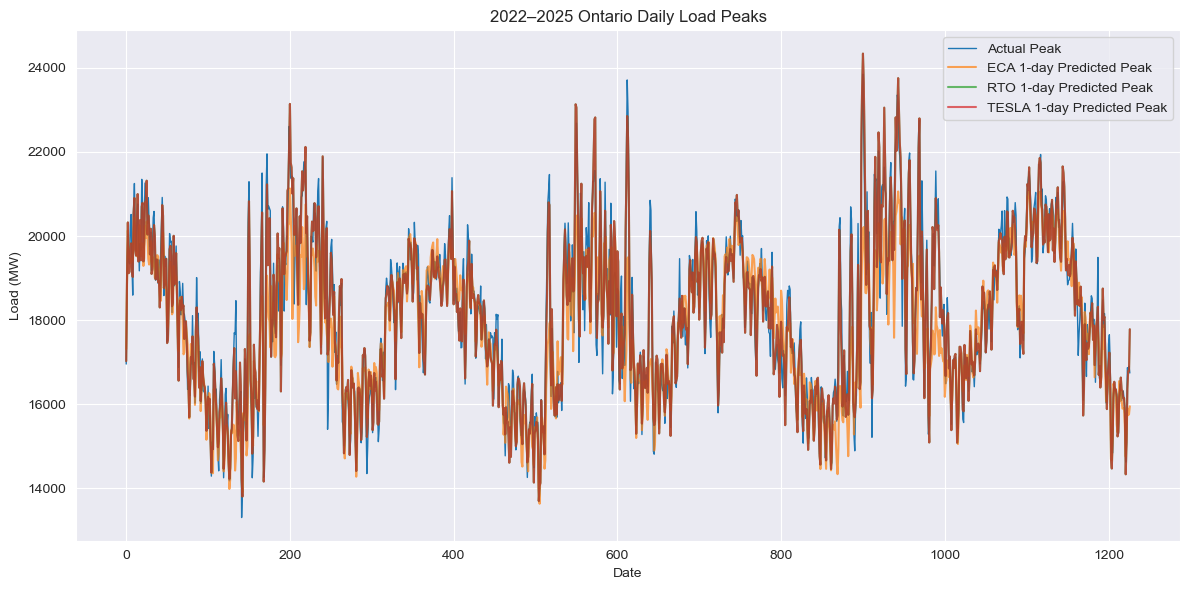

In [26]:
# Draw the trends of actual peaks and predicted peaks in chronological order
plt.figure(figsize=(12, 6))
plt.plot(daily_peaks.index, daily_peaks['actual_peak'], label='Actual Peak', linewidth=1.0)
plt.plot(daily_peaks.index, daily_peaks['ECA_peak_1d'], label='ECA 1-day Predicted Peak', alpha=0.7)
plt.plot(daily_peaks.index, daily_peaks['RTO_peak_1d'], label='RTO 1-day Predicted Peak', alpha=0.7)
plt.plot(daily_peaks.index, daily_peaks['TESLA_pred_peak_1d'], label='TESLA 1-day Predicted Peak', alpha=0.7)
plt.title('2022–2025 Ontario Daily Load Peaks')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.tight_layout()
plt.show()

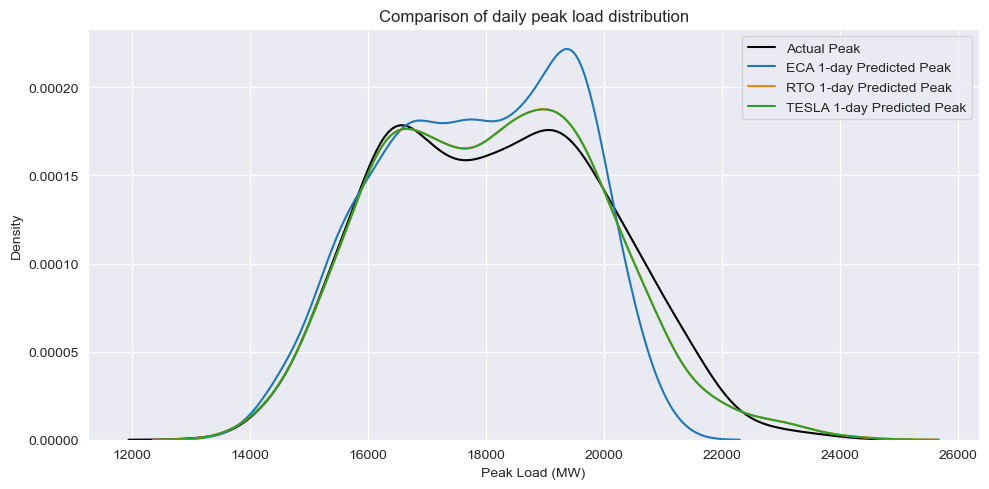

In [27]:
# Draw the distribution curve between the actual peak and the predicted peak
plt.figure(figsize=(10, 5))
for col, color, label in zip(['actual_peak', 'ECA_peak_1d', 'RTO_peak_1d', 'TESLA_pred_peak_1d'],
                             ['black', 'tab:blue', 'tab:orange', 'tab:green'],
                             ['Actual Peak', 'ECA 1-day Predicted Peak', 'RTO 1-day Predicted Peak',
                              'TESLA 1-day Predicted Peak']):
    # Use KDE curves to display the distribution, do not enable fill to avoid dtype problems
    sns.kdeplot(daily_peaks[col], label=label, color=color, linewidth=1.5)
plt.title('Comparison of daily peak load distribution')
plt.xlabel('Peak Load (MW)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

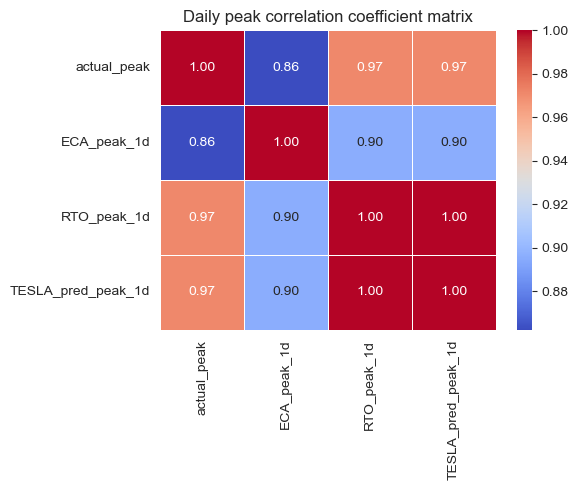

In [28]:
# Calculate the correlation coefficient matrix and draw the heat map
corr = daily_peaks[['actual_peak', 'ECA_peak_1d', 'RTO_peak_1d', 'TESLA_pred_peak_1d']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Daily peak correlation coefficient matrix')
plt.tight_layout()
plt.show()

In [29]:
# Label Monthly 4CP (Jun–Sep) — top 4 days by actual_peak *per month*
daily_peaks['is_CP'] = 0
summer_mask = daily_peaks['month'].between(6, 9)
for (y, m), sub in daily_peaks[summer_mask].groupby(['year', 'month']):
    if len(sub) < 20:  # skip partial months
        continue
    top_idx = sub.nlargest(4, 'actual_peak').index
    daily_peaks.loc[top_idx, 'is_CP'] = 1

daily_peaks[daily_peaks['is_CP'] == 1][['timestamp', 'actual_peak', 'year', 'month']].sort_values(
    ['year', 'month', 'actual_peak'], ascending=[True, True, False])

,timestamp,actual_peak,year,month
172,2022-06-22,21953.98,2022,6
166,2022-06-16,21499.52,2022,6
171,2022-06-21,21203.92,2022,6
174,2022-06-24,20714.83,2022,6
199,2022-07-19,22607.37,2022,7
200,2022-07-20,21850.29,2022,7
203,2022-07-23,21422.94,2022,7
201,2022-07-21,21378.51,2022,7
240,2022-08-29,21870.74,2022,8
218,2022-08-07,21778.08,2022,8


In [30]:
# Features and Split (ALL months). TS wrappers align to X; no scalers anywhere.
def pick_main_feature(cols):
    for cand in ['ECA_peak_1d', 'RTO_peak_1d', 'TESLA_pred_peak_1d']:
        if cand in cols:
            return cand
    return cols[0]


forecast_files = range(1, 7)
selected_feature = 'TESLA'  # or 'RTO', 'TESLA', or 'ALL'
feature_cols = []
if selected_feature == 'ECA':
    feature_cols = [f'ECA_peak_{n}d' for n in forecast_files]
elif selected_feature == 'RTO':
    feature_cols = [f'RTO_peak_{n}d' for n in forecast_files]
elif selected_feature == 'TESLA':
    feature_cols = [f'TESLA_pred_peak_{n}d' for n in forecast_files]
else:
    for base in ['ECA_peak', 'RTO_peak', 'TESLA_pred_peak']:
        for n in forecast_files:
            feature_cols.append(f'{base}_{n}d')

MAIN_FEAT = pick_main_feature(feature_cols)

model_df = daily_peaks[['timestamp', 'year', 'month', 'actual_peak', 'is_CP'] + feature_cols].copy()

# Split: ALL months — 2022–2023 train; 2024–2025 test
separation = 2024
train_df = model_df[model_df['year'] < separation].copy()
test_df = model_df[model_df['year'] >= separation].copy()

X_train = train_df[feature_cols]
y_train = train_df['is_CP'].astype(int).values
X_test = test_df[feature_cols]
y_test = test_df['is_CP'].astype(int).values

In [31]:
USE_TOP_PCT_TRAIN = True  # True Enable "up to 10% of samples as training set"; False maintains the original training set
TOP_PCT = 0.10  # 10%
TOP_BY = 'actual_peak'
TOP_SCOPE = 'overall'

if USE_TOP_PCT_TRAIN:
    # 1) Select the range to calculate the threshold
    scope_df = model_df if TOP_SCOPE == 'overall' else train_df
    # 2) Calculate the quantile threshold and take Top‑K%
    thr = scope_df[TOP_BY].quantile(1.0 - TOP_PCT)
    scope_top_idx = scope_df.index[scope_df[TOP_BY] >= thr]

    if TOP_SCOPE == 'overall':
        train_top_df = model_df.loc[scope_top_idx].copy()
    else:
        train_top_df = train_df.loc[train_df.index.intersection(scope_top_idx)].copy()

    train_top_df = train_top_df.sort_values('timestamp').reset_index(drop=True)

    X_train = train_top_df[feature_cols]
    y_train = train_top_df['is_CP'].astype(int).values

    print(f"[INFO] Use top {int(TOP_PCT * 100)}% by '{TOP_BY}' for training "
          f"from scope='{TOP_SCOPE}': {len(y_train)} rows (sorted by timestamp).")
else:
    print("[INFO] Use original training split without top-percent filtering.")

[INFO] Use top 10% by 'actual_peak' for training from scope='overall': 123 rows (sorted by timestamp).


In [32]:
def compute_fill_values(df):
    arr = df.replace([np.inf, -np.inf], np.nan)
    return arr.median(numeric_only=True)


def impute_like_train(df, fill_values):
    arr = df.replace([np.inf, -np.inf], np.nan)
    arr = arr.ffill().bfill()
    for c, mv in fill_values.items():
        if c in arr.columns:
            arr[c] = arr[c].fillna(float(mv))
    return arr.fillna(0.0)


def sanitize_scores(s, base=0.5):
    s = np.asarray(s, dtype=float)
    s = np.nan_to_num(s, nan=base, posinf=1.0, neginf=0.0)
    return np.clip(s, 0.0, 1.0)


# --- TS wrappers fixed to align on X (no resizing hacks, no scalers) ---
class ARIMAClassifier:
    def __init__(self, order=(2, 1, 2)):
        self.order = order
        self.model_ = None
        self.endog_name = None
        self.exog_names = []
        self.fill_values_ = None  # to store fill values for imputing

    def fit(self, X, y):
        df = X.copy()
        if df.shape[1] == 0 or len(df) < 10:
            self.model_ = None
            return self

        self.endog_name = df.columns[0]
        self.exog_names = list(df.columns[1:])

        self.fill_values_ = compute_fill_values(df)

        df = impute_like_train(df, self.fill_values_)
        endog = df[self.endog_name].astype(float)
        exog = df[self.exog_names].astype(float) if len(self.exog_names) > 0 else None

        try:
            self.model_ = SARIMAX(endog, exog=exog, order=self.order,
                                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        except Exception:
            self.model_ = None
        return self

    def predict_proba(self, X):
        n = len(X)
        if self.model_ is None or n == 0:
            probs = np.full(n, 0.5, dtype=float)
            probs = sanitize_scores(probs)
            return np.column_stack([1 - probs, probs])

        # Take exogenous variables in order of training
        df = X.copy()
        fill_vals = self.fill_values_ if self.fill_values_ is not None else compute_fill_values(df)
        df_imp = impute_like_train(df, fill_vals)
        exog_new = df_imp[self.exog_names].astype(float) if len(self.exog_names) > 0 else None

        try:
            forecast = self.model_.get_forecast(steps=n, exog=exog_new).predicted_mean
            z = (forecast - forecast.min()) / (forecast.max() - forecast.min() + 1e-12)
            probs = sanitize_scores(z.values if hasattr(z, "values") else z)
        except Exception:
            probs = np.full(n, 0.5, dtype=float)
            probs = sanitize_scores(probs)

        return np.column_stack([1 - probs, probs])


class LSTMClassifier:
    def __init__(self, seq_length=30, lstm_units=64):
        self.seq_length = seq_length
        self.lstm_units = lstm_units
        self.model = None
        self.feature_names = None  # Keep the order of columns during training
        self.fill_values_ = None

    def _make_sequences(self, X_2d):
        A = np.asarray(X_2d, dtype=float)
        n, f = A.shape
        L = self.seq_length
        if n <= L:
            return np.empty((0, L, f), dtype=float), np.array([], dtype=int)
        Xs = np.stack([A[i:i + L] for i in range(n - L)], axis=0)
        idx = np.arange(L, n, dtype=int)
        return Xs, idx

    def fit(self, X, y):
        # Record and lock the sequence of feature columns
        self.feature_names = list(X.columns)
        self.fill_values_ = compute_fill_values(X[self.feature_names])
        X_imp = impute_like_train(X[self.feature_names], self.fill_values_)
        A = X_imp.values

        Xs, idx = self._make_sequences(A)
        if len(Xs) == 0:
            self.model = None
            return self
        y_arr = np.asarray(y, dtype=float)[idx]

        self.model = Sequential([
            Input(shape=(self.seq_length, A.shape[1])),
            LSTM(self.lstm_units, return_sequences=True),
            Dropout(0.2),
            LSTM(self.lstm_units // 2),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

        try:
            self.model.fit(Xs, y_arr, epochs=30, batch_size=32, verbose=0,
                           callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)])
        except Exception:
            self.model = None
        return self

    def predict_proba(self, X):
        n = len(X)
        if self.model is None or n == 0:
            probs = np.full(n, 0.5, dtype=float)
            probs = sanitize_scores(probs)
            return np.column_stack([1 - probs, probs])

        # Features are selected in the order of columns during training
        Xp = X[self.feature_names].copy()
        fill_vals = self.fill_values_ if self.fill_values_ is not None else compute_fill_values(Xp)
        X_imp = impute_like_train(Xp, fill_vals)
        A = X_imp.values

        Xs, idx = self._make_sequences(A)
        if len(Xs) == 0:
            probs = np.full(n, 0.5, dtype=float)
        else:
            p = self.model.predict(Xs, verbose=0).flatten()
            base = float(np.nanmin(p)) if len(p) > 0 else 0.5
            probs = np.full(n, base, dtype=float)
            probs[idx] = p

        probs = sanitize_scores(probs)
        return np.column_stack([1 - probs, probs])


class GRUClassifier:
    def __init__(self, seq_length=30, gru_units=64):
        self.seq_length = seq_length
        self.gru_units = gru_units
        self.model = None
        self.feature_names = None
        self.fill_values_ = None

    def _make_sequences(self, X_2d):
        A = np.asarray(X_2d, dtype=float)
        n, f = A.shape
        L = self.seq_length
        if n <= L:
            return np.empty((0, L, f), dtype=float), np.array([], dtype=int)
        Xs = np.stack([A[i:i + L] for i in range(n - L)], axis=0)
        idx = np.arange(L, n, dtype=int)
        return Xs, idx

    def fit(self, X, y):
        self.feature_names = list(X.columns)
        self.fill_values_ = compute_fill_values(X[self.feature_names])
        X_imp = impute_like_train(X[self.feature_names], self.fill_values_)
        A = X_imp.values

        Xs, idx = self._make_sequences(A)
        if len(Xs) == 0:
            self.model = None
            return self
        y_arr = np.asarray(y, dtype=float)[idx]

        self.model = Sequential([
            Input(shape=(self.seq_length, A.shape[1])),
            GRU(self.gru_units, return_sequences=True),
            Dropout(0.2),
            GRU(self.gru_units // 2),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

        try:
            self.model.fit(Xs, y_arr, epochs=30, batch_size=32, verbose=0,
                           callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)])
        except Exception:
            self.model = None
        return self

    def predict_proba(self, X):
        n = len(X)
        if self.model is None or n == 0:
            probs = np.full(n, 0.5, dtype=float)
            probs = sanitize_scores(probs)
            return np.column_stack([1 - probs, probs])

        Xp = X[self.feature_names].copy()
        fill_vals = self.fill_values_ if self.fill_values_ is not None else compute_fill_values(Xp)
        X_imp = impute_like_train(Xp, fill_vals)
        A = X_imp.values

        Xs, idx = self._make_sequences(A)
        if len(Xs) == 0:
            probs = np.full(n, 0.5, dtype=float)
        else:
            p = self.model.predict(Xs, verbose=0).flatten()
            base = float(np.nanmin(p)) if len(p) > 0 else 0.5
            probs = np.full(n, base, dtype=float)
            probs[idx] = p

        probs = sanitize_scores(probs)
        return np.column_stack([1 - probs, probs])

In [33]:
models = {
    "Logistic Regression": Pipeline([('imp', SimpleImputer(strategy='median')),
                                     ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))]),
    "Decision Tree": Pipeline([('imp', SimpleImputer(strategy='median')),
                               ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))]),
    "Random Forest": Pipeline([('imp', SimpleImputer(strategy='median')),
                               ('clf',
                                RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))]),
    "Extra Trees": Pipeline([('imp', SimpleImputer(strategy='median')),
                             ('clf', ExtraTreesClassifier(n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1))]),
    "Gradient Boosting": Pipeline([('imp', SimpleImputer(strategy='median')),
                                   ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))]),
    "AdaBoost": Pipeline([('imp', SimpleImputer(strategy='median')),
                          ('clf', AdaBoostClassifier(random_state=RANDOM_STATE))]),
    "Hist Gradient Boosting": Pipeline([('imp', SimpleImputer(strategy='median')),
                                        ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))]),
    "KNN": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', KNeighborsClassifier(n_neighbors=5))]),
    "SVM (Linear)": Pipeline([('imp', SimpleImputer(strategy='median')),
                              ('clf', SVC(kernel='linear', probability=True, random_state=RANDOM_STATE))]),
    "SVM (RBF)": Pipeline([('imp', SimpleImputer(strategy='median')),
                           ('clf', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE))]),
    "GaussianNB": Pipeline([('imp', SimpleImputer(strategy='median')),
                            ('clf', GaussianNB())]),
    "LDA": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', LinearDiscriminantAnalysis())]),
    "QDA": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', QuadraticDiscriminantAnalysis(reg_param=0.1))]),
    "MLP": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=RANDOM_STATE))]),
    # TS wrappers (no pipeline; they handle raw features internally)
    "ARIMA": ARIMAClassifier(order=(2, 1, 2)),
    "LSTM": LSTMClassifier(seq_length=30, lstm_units=64),
    "GRU": GRUClassifier(seq_length=30, gru_units=64),
}

results = []
proba_dict = {}

In [34]:
THRESH_PCTL = 0.95  # percentile threshold for determining high-load (CP) days
THRESH_FACTOR = 4  # weight multiplier applied to high-load days


def wei_classification(y_true, prob, threshold_percentile=THRESH_PCTL, weight_factor=THRESH_FACTOR):
    y_true_array = np.asarray(y_true).astype(float)
    prob = np.asarray(prob).astype(float)
    # quantile on labels (binary -> typically 1.0 if any positives)
    threshold = np.quantile(y_true_array, threshold_percentile)
    weights = np.where(y_true_array >= threshold, weight_factor, 1.0)
    weighted_error = np.abs(prob - y_true_array)
    total_w = weights.sum() + 1e-12
    wei = (weights * weighted_error).sum() / total_w
    tot_err = (weights * weighted_error).sum()
    if tot_err > 0:
        share = (weights[y_true_array >= threshold] * weighted_error[y_true_array >= threshold]).sum() / tot_err
    else:
        share = 0.0
    # return both the index and the share attributable to the high-weight class
    return float(wei), float(share)

In [35]:
# Train all models and compute probabilities on test
fitted_models = {}
prob_test = {}
for name, m in models.items():
    try:
        m.fit(X_train, y_train)
        fitted_models[name] = m
        if hasattr(m, "predict_proba"):
            s = m.predict_proba(X_test)[:, 1]
        else:
            # fall back to decision scores (should not happen for our set)
            s = m.decision_function(X_test)
            s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        prob_test[name] = sanitize_scores(s)
    except Exception as e:
        print(f"[WARN] {name} failed during fit/predict: {e}")
        continue

# Overall trend metrics for 2024 only
test_2024 = test_df[test_df['year'] == 2024].copy()
X_2024 = test_2024[feature_cols]
y_2024 = test_2024['is_CP'].astype(int).values

overall_trend_2024 = {}

In [36]:
fitted_models = {}
prob_test = {}
fit_failures = {}

for name, m in models.items():
    try:
        m.fit(X_train, y_train)
        fitted_models[name] = m
        if hasattr(m, "predict_proba"):
            s = m.predict_proba(X_test)[:, 1]
        else:
            s = m.decision_function(X_test)
            s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        prob_test[name] = sanitize_scores(s)
    except Exception as e:
        fit_failures[name] = str(e)

print("[INFO] Fitted models:")
for k in models.keys():
    if k in fitted_models:
        print(f"  - {k}: OK")
    else:
        print(f"  - {k}: FAILED")

if fit_failures:
    print("[INFO] Failure reasons:")
    for k, v in fit_failures.items():
        print(f"  - {k}: {v}")

USE_ADAPTIVE_THRESHOLD = True
VAL_SCOPE = 'train'
EPS = 1e-12


def predict_proba_sanitized(model, X):
    if hasattr(model, "predict_proba"):
        s = model.predict_proba(X)[:, 1]
    else:
        s = model.decision_function(X)
        s = (s - s.min()) / (s.max() - s.min() + EPS)
    return sanitize_scores(s)


# validation split for threshold search
if VAL_SCOPE == 'train':
    X_val = train_df[feature_cols]
    y_val = train_df['is_CP'].astype(int).values
elif VAL_SCOPE == 'year=2023':
    val_df = model_df[model_df['year'] == 2023]
    X_val = val_df[feature_cols]
    y_val = val_df['is_CP'].astype(int).values
else:
    X_val = train_df[feature_cols]
    y_val = train_df['is_CP'].astype(int).values

thr_by_model = {}
val_pos_rate = float(y_val.mean())

for name, m in fitted_models.items():
    try:
        s_val = predict_proba_sanitized(m, X_val)
        if np.allclose(np.max(s_val), np.min(s_val)):
            # constant scores -> fallback to fraction-based quantile
            thr = np.quantile(s_val, 1.0 - val_pos_rate) if 0.0 < val_pos_rate < 1.0 else 0.5
        else:
            prec, rec, ths = precision_recall_curve(y_val, s_val)
            if len(ths) == 0:
                thr = 0.5
            else:
                f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + EPS)
                thr = float(ths[int(np.nanargmax(f1s))])
        thr_by_model[name] = thr
    except Exception as e:
        thr_by_model[name] = None

print("[INFO] Adaptive thresholds learned:")
for name in models.keys():
    v = thr_by_model.get(name, None)
    if v is None:
        print(f"  - {name}: N/A")
    else:
        print(f"  - {name}: {v:.6f}")


# helper: apply threshold with top-k fallback to avoid all-negative/all-positive
def apply_threshold_with_fallback(scores, base_thr, train_pos_rate):
    n = len(scores)
    y_pred = (scores >= base_thr).astype(int)
    if n == 0:
        return y_pred, base_thr
    # if all negative -> pick top-k by train positive rate
    if y_pred.sum() == 0 and train_pos_rate > 0:
        k = max(1, int(round(train_pos_rate * n)))
        if k >= n:
            return np.ones(n, dtype=int), float(np.min(scores))
        kth = np.partition(scores, n - k)[n - k]
        y_pred = (scores >= kth).astype(int)
        return y_pred, float(kth)
    # if all positive -> trim by (1 - train_pos_rate)
    if y_pred.sum() == n and train_pos_rate < 1:
        k0 = max(1, int(round((1 - train_pos_rate) * n)))
        kth = np.partition(scores, k0 - 1)[k0 - 1]
        y_pred = (scores > kth).astype(int)
        return y_pred, float(kth)
    return y_pred, base_thr


test_2024 = test_df[test_df['year'] == 2024].copy()
X_2024 = test_2024[feature_cols]
y_2024 = test_2024['is_CP'].astype(int).values

overall_trend_2024_adaptive = {}
for name, m in fitted_models.items():
    try:
        s24 = predict_proba_sanitized(m, X_2024)
        base_thr = thr_by_model.get(name, 0.5) if USE_ADAPTIVE_THRESHOLD else 0.5
        # robust fallback to avoid degenerate all-0/all-1 predictions
        y_pred, used_thr = apply_threshold_with_fallback(s24, base_thr, val_pos_rate)

        prec = precision_score(y_2024, y_pred, zero_division=0)
        rec = recall_score(y_2024, y_pred, zero_division=0)
        f1 = f1_score(y_2024, y_pred, zero_division=0)
        acc = accuracy_score(y_2024, y_pred)
        try:
            auc = roc_auc_score(y_2024, s24) if len(np.unique(y_2024)) > 1 else np.nan
        except Exception:
            auc = np.nan
        wei_val, wei_share = wei_classification(y_2024, s24)

        overall_trend_2024_adaptive[name] = dict(
            Precision=prec, Recall=rec, F1score=f1, Accuracy=acc, AUC=auc,
            WEI=wei_val, WEI_share=wei_share,
            thr=used_thr, pos_pred=int(y_pred.sum())
        )
    except Exception as e:
        overall_trend_2024_adaptive[name] = dict(
            Precision=np.nan, Recall=np.nan, F1score=np.nan, Accuracy=np.nan,
            AUC=np.nan, WEI=np.nan, WEI_share=np.nan, thr=np.nan, pos_pred=0,
            error=str(e)
        )

overall_trend_df_2024_adaptive = (
    pd.DataFrame.from_dict(overall_trend_2024_adaptive, orient='index')
    .rename_axis('model').reset_index()
)
print("Overall trend metrics on 2024 with adaptive thresholds (with fallback):")
display(overall_trend_df_2024_adaptive.sort_values(['AUC', 'F1score', 'Precision'], ascending=[False, False, False]))

[INFO] Fitted models:
  - Logistic Regression: OK
  - Decision Tree: OK
  - Random Forest: OK
  - Extra Trees: OK
  - Gradient Boosting: OK
  - AdaBoost: OK
  - Hist Gradient Boosting: OK
  - KNN: OK
  - SVM (Linear): OK
  - SVM (RBF): OK
  - GaussianNB: OK
  - LDA: OK
  - QDA: OK
  - MLP: OK
  - ARIMA: OK
  - LSTM: OK
  - GRU: OK
[INFO] Adaptive thresholds learned:
  - Logistic Regression: 0.232705
  - Decision Tree: 1.000000
  - Random Forest: 0.606667
  - Extra Trees: 1.000000
  - Gradient Boosting: 0.882306
  - AdaBoost: 0.477957
  - Hist Gradient Boosting: 0.428866
  - KNN: 0.600000
  - SVM (Linear): 0.230760
  - SVM (RBF): 0.697951
  - GaussianNB: 0.003374
  - LDA: 0.209618
  - QDA: 0.063406
  - MLP: 0.000000
  - ARIMA: 0.788584
  - LSTM: 0.300360
  - GRU: 0.177223
Overall trend metrics on 2024 with adaptive thresholds (with fallback):


,model,Precision,Recall,F1score,Accuracy,AUC,WEI,WEI_share,thr,pos_pred
4,Gradient Boosting,0.928571,0.8125,0.866667,0.989071,0.992857,0.047325,1.0,8.823060e-01,14
3,Extra Trees,1.000000,0.8750,0.933333,0.994536,0.990714,0.049273,1.0,1.000000e+00,14
11,LDA,0.545455,0.7500,0.631579,0.961749,0.968571,0.050866,1.0,2.096175e-01,22
14,ARIMA,0.916667,0.6875,0.785714,0.983607,0.968214,0.350149,1.0,7.885835e-01,12
8,SVM (Linear),0.521739,0.7500,0.615385,0.959016,0.966875,0.074323,1.0,2.307604e-01,23
0,Logistic Regression,0.500000,0.7500,0.600000,0.956284,0.966071,0.057321,1.0,2.327050e-01,24
5,AdaBoost,0.545455,0.7500,0.631579,0.961749,0.961964,0.348121,1.0,4.779568e-01,22
1,Decision Tree,0.576923,0.9375,0.714286,0.967213,0.953036,0.032787,1.0,1.000000e+00,26
2,Random Forest,0.933333,0.8750,0.903226,0.991803,0.945536,0.153579,1.0,6.066667e-01,15
6,Hist Gradient Boosting,0.866667,0.8125,0.838710,0.986339,0.912500,0.222727,1.0,4.288662e-01,15


In [37]:
for name, m in fitted_models.items():
    try:
        s24 = m.predict_proba(X_2024)[:, 1] if hasattr(m, "predict_proba") else m.decision_function(X_2024)
        s24 = sanitize_scores(s24)
        y_pred = (s24 >= 0.5).astype(int)
        precision = precision_score(y_2024, y_pred, zero_division=0)
        recall = recall_score(y_2024, y_pred, zero_division=0)
        f1 = f1_score(y_2024, y_pred, zero_division=0)
        accuracy = accuracy_score(y_2024, y_pred)
        auc_val = roc_auc_score(y_2024, s24) if len(np.unique(y_2024)) > 1 else np.nan
        wei_val, wei_share = wei_classification(y_2024, s24)
        overall_trend_2024[name] = {
            'Precision': precision,
            'Accuracy': accuracy,
            'Recall': recall,
            'AUC': auc_val,
            'F1score': f1,
            'WEI': wei_val,
            'WEI_share': wei_share
        }
    except Exception as e:
        overall_trend_2024[name] = {'Precision': np.nan, 'Accuracy': np.nan, 'Recall': np.nan, 'AUC': np.nan,
                                    'F1score': np.nan, 'WEI': np.nan, 'WEI_share': np.nan}
        print(f"[WARN] Trend metrics failed for {name}: {e}")

overall_trend_df_2024 = pd.DataFrame.from_dict(overall_trend_2024, orient='index').rename_axis('model').reset_index()
for col in ['Precision', 'Accuracy', 'Recall', 'AUC', 'F1score', 'WEI', 'WEI_share']:
    if col in overall_trend_df_2024.columns:
        overall_trend_df_2024[col] = overall_trend_df_2024[col].astype(float).round(4)

print("Overall trend metrics on 2024 (ALL months):")
display(overall_trend_df_2024.sort_values(['AUC', 'F1score', 'Precision'], ascending=[False, False, False]))

Overall trend metrics on 2024 (ALL months):


,model,Precision,Accuracy,Recall,AUC,F1score,WEI,WEI_share
4,Gradient Boosting,0.7368,0.9809,0.8750,0.9929,0.8000,0.0473,1.0
3,Extra Trees,0.6364,0.9727,0.8750,0.9907,0.7368,0.0493,1.0
11,LDA,0.8000,0.9809,0.7500,0.9686,0.7742,0.0509,1.0
14,ARIMA,0.1684,0.7842,1.0000,0.9682,0.2883,0.3501,1.0
8,SVM (Linear),0.8333,0.9781,0.6250,0.9669,0.7143,0.0743,1.0
0,Logistic Regression,0.8000,0.9809,0.7500,0.9661,0.7742,0.0573,1.0
5,AdaBoost,0.6000,0.9672,0.7500,0.9620,0.6667,0.3481,1.0
1,Decision Tree,0.5769,0.9672,0.9375,0.9530,0.7143,0.0328,1.0
2,Random Forest,0.6087,0.9699,0.8750,0.9455,0.7179,0.1536,1.0
6,Hist Gradient Boosting,0.8667,0.9863,0.8125,0.9125,0.8387,0.2227,1.0


In [38]:
# Monthly Precision@4 / Recall@4 for each model across the test period (Jun–Sep months)
def aggregated_p_r_at_4(df, scores):
    df = df.copy()
    df['score'] = scores
    total_hits = 0
    total_true = 0
    months = 0
    for (y, m), sub in df.groupby(['year', 'month']):
        if not (6 <= m <= 9):
            continue
        if len(sub) < 20:
            continue
        top4 = sub.nlargest(4, 'score')
        hits = int(top4['is_CP'].sum())
        denom = int(sub['is_CP'].sum())
        total_hits += hits
        total_true += denom
        months += 1
    precision4 = (total_hits / (4.0 * months)) if months > 0 else np.nan
    recall4 = (total_hits / total_true) if total_true > 0 else np.nan
    return precision4, recall4, months, total_true


rows = []
for name, s in prob_test.items():
    p4, r4, nmonths, tot_true = aggregated_p_r_at_4(test_df, s)
    rows.append({'Model': name, 'precision_at_4': p4, 'recall_at_4': r4})

p4r4_summary = pd.DataFrame(rows).sort_values('precision_at_4', ascending=False)
p4r4_summary['precision_at_4'] = p4r4_summary['precision_at_4'].round(4)
p4r4_summary['recall_at_4'] = p4r4_summary['recall_at_4'].round(4)

print("Aggregated Precision@4 / Recall@4 (single number per model):")
display(p4r4_summary[['Model', 'precision_at_4', 'recall_at_4']])

Aggregated Precision@4 / Recall@4 (single number per model):


,Model,precision_at_4,recall_at_4
4,Gradient Boosting,0.9375,0.9375
3,Extra Trees,0.9375,0.9375
2,Random Forest,0.8750,0.8750
1,Decision Tree,0.8750,0.8750
0,Logistic Regression,0.7500,0.7500
6,Hist Gradient Boosting,0.7500,0.7500
8,SVM (Linear),0.7500,0.7500
14,ARIMA,0.7500,0.7500
11,LDA,0.7500,0.7500
5,AdaBoost,0.6875,0.6875


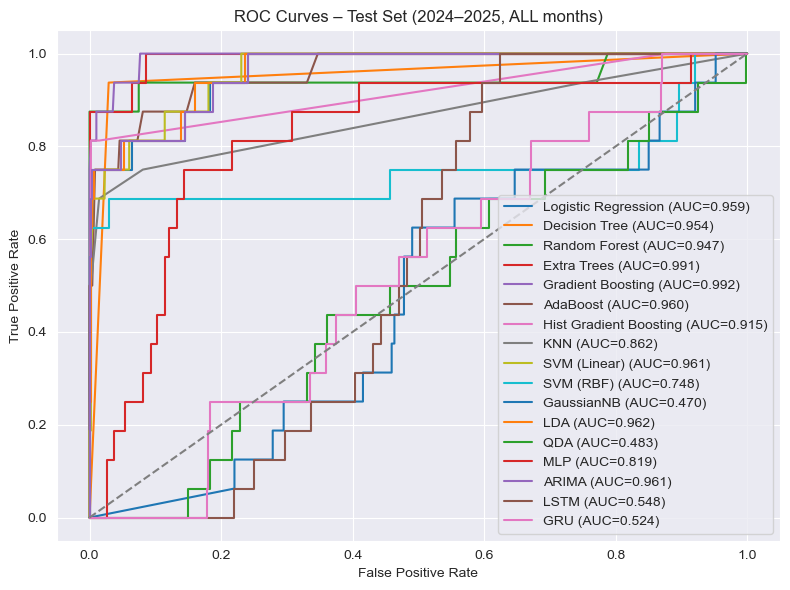

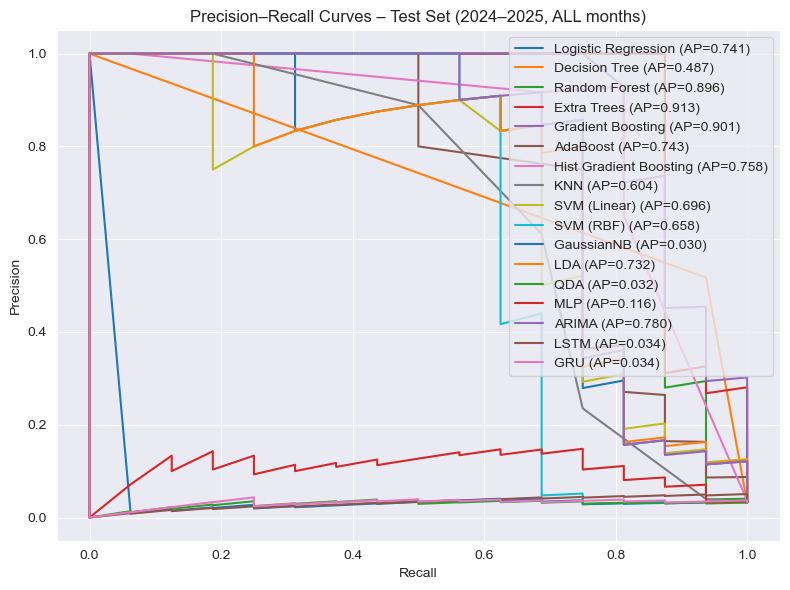

In [39]:
# ROC and Precision-Recall curves for 2024 (overall trend view)
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve as sk_roc_curve, auc as sk_auc

X_all = X_test
y_all = y_test

has_both_classes = (len(np.unique(y_all)) > 1)

# ROC
plt.figure(figsize=(8, 6))
plotted_any = False
if not has_both_classes:
    plt.text(0.5, 0.5, "ROC undefined for test set (single class in y).", ha='center', va='center')
else:
    for name, m in fitted_models.items():
        try:
            s = m.predict_proba(X_all)[:, 1] if hasattr(m, 'predict_proba') else m.decision_function(X_all)
            s = sanitize_scores(s)
            fpr, tpr, _ = sk_roc_curve(y_all, s)
            roc_auc_val = sk_auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_val:.3f})")
            plotted_any = True
        except Exception:
            continue
    plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Test Set (2024–2025, ALL months)')
if plotted_any:
    plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall
plt.figure(figsize=(8, 6))
plotted_any_pr = False
if y_all.sum() == 0:
    plt.text(0.5, 0.5, "PR undefined for test set (no positive class).", ha='center', va='center')
else:
    for name, m in fitted_models.items():
        try:
            s = m.predict_proba(X_all)[:, 1] if hasattr(m, 'predict_proba') else m.decision_function(X_all)
            s = sanitize_scores(s)
            precision, recall, _ = precision_recall_curve(y_all, s)
            ap_val = average_precision_score(y_all, s)
            plt.plot(recall, precision, label=f"{name} (AP={ap_val:.3f})")
            plotted_any_pr = True
        except Exception:
            continue

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves – Test Set (2024–2025, ALL months)')
if plotted_any_pr:
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [40]:
selected_model = "Extra Trees"  # change to any key in `models`
start_month, end_month = 6, 9

period_mask = (test_df['month'] >= start_month) & (test_df['month'] <= end_month)
period_data = test_df.loc[period_mask].copy()

if selected_model in fitted_models and not period_data.empty:
    mdl = fitted_models[selected_model]
    if hasattr(mdl, "predict_proba"):
        p = mdl.predict_proba(period_data[feature_cols])[:, 1]
    else:
        s = mdl.decision_function(period_data[feature_cols])
        p = (s - s.min()) / (s.max() - s.min() + 1e-12)
    period_data[f"{selected_model}_prob"] = p

    for year in sorted(period_data['year'].unique()):
        year_data = period_data[period_data['year'] == year]
        print(f"\n=== {year} results — {selected_model} ===")
        for month in sorted(year_data['month'].unique()):
            month_data = year_data[year_data['month'] == month]
            if len(month_data) < 1:
                continue
            sub = month_data[[f"{selected_model}_prob", "actual_peak", "is_CP", "timestamp"]].sort_values(
                f"{selected_model}_prob", ascending=False).head(4)
            display(sub)
            hits = int(sub['is_CP'].sum())
            total_cp_days = int(month_data['is_CP'].sum())
            precision4 = hits / 4.0
            print(f"Hits: {hits}/4 | True CP in month: {total_cp_days} | Precision@4: {precision4:.2%}")
            if total_cp_days > 0:
                recall4 = hits / total_cp_days
                print(f"Recall@4: {recall4:.2%}")
else:
    print("No data available for the selected model or period.")


=== 2024 results — Extra Trees ===


,Extra Trees_prob,actual_peak,is_CP,timestamp
898,1.0,21647.62,1,2024-06-17
899,1.0,23097.18,1,2024-06-18
900,1.0,23851.82,1,2024-06-19
901,1.0,22485.78,1,2024-06-20


Hits: 4/4 | True CP in month: 4 | Precision@4: 100.00%
Recall@4: 100.00%


,Extra Trees_prob,actual_peak,is_CP,timestamp
919,1.0,22025.51,1,2024-07-08
940,1.0,22244.97,1,2024-07-29
942,1.0,23355.86,1,2024-07-31
941,1.0,22371.08,1,2024-07-30


Hits: 4/4 | True CP in month: 4 | Precision@4: 100.00%
Recall@4: 100.00%


,Extra Trees_prob,actual_peak,is_CP,timestamp
943,1.0,23179.24,1,2024-08-01
944,1.0,22103.13,1,2024-08-02
968,1.0,22466.42,1,2024-08-26
969,1.0,22749.83,1,2024-08-27


Hits: 4/4 | True CP in month: 4 | Precision@4: 100.00%
Recall@4: 100.00%


,Extra Trees_prob,actual_peak,is_CP,timestamp
992,1.0000,20886.45,1,2024-09-19
989,1.0000,21546.47,1,2024-09-16
985,0.3075,19582.95,0,2024-09-12
990,0.2900,20360.78,1,2024-09-17


Hits: 3/4 | True CP in month: 4 | Precision@4: 75.00%
Recall@4: 75.00%
